In [1]:
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from fbprophet import Prophet

In [3]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [4]:
from oanda_bot import Bot

class MyBot(Bot):
    def strategy(self):
        fast_ma = self.sma(period=5)
        slow_ma = self.sma(period=25)
        # golden cross
        self.sell_exit = self.buy_entry = (fast_ma > slow_ma) & (
            fast_ma.shift() <= slow_ma.shift()
        )
        # dead cross
        self.buy_exit = self.sell_entry = (fast_ma < slow_ma) & (
            fast_ma.shift() >= slow_ma.shift()
        )


In [5]:
df = Bot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument='USD_JPY',
    granularity='M1', # 15 second candlestick
)._candles(from_date="2021-1-20", to_date="2021-2-4")

df.tail()

,O,H,L,C,V
T,,,,,
2021-02-05 18:01:00+00:00,105.378,105.388,105.378,105.383,33.0
2021-02-05 18:02:00+00:00,105.384,105.390,105.382,105.382,15.0
2021-02-05 18:03:00+00:00,105.380,105.380,105.372,105.372,11.0
2021-02-05 18:04:00+00:00,105.372,105.378,105.370,105.378,17.0
2021-02-05 18:05:00+00:00,105.376,105.376,105.370,105.374,25.0


In [6]:
df.to_csv('USD_JPY_M1_20210120_20210204.csv')

In [7]:
df_minute = pd.read_csv('USD_JPY_M1_20210120_20210204.csv')

In [47]:
df_minute_prophet = df_minute[['T', 'C']].copy()
df_minute_prophet.columns = ['ds', 'y']
df_minute_prophet['ds'] = pd.to_datetime(df_minute_prophet['ds'].apply(lambda x:x[:-6]))

test_num = 120
shift = 200
df_train = df_minute_prophet[:-shift][:-test_num]
df_test = df_minute_prophet[:-shift][-test_num:]

In [48]:
df_test

,ds,y
17283,2021-02-05 12:46:00,105.700
17284,2021-02-05 12:47:00,105.700
17285,2021-02-05 12:48:00,105.700
17286,2021-02-05 12:49:00,105.695
17287,2021-02-05 12:50:00,105.699
...,...,...
17398,2021-02-05 14:41:00,105.540
17399,2021-02-05 14:42:00,105.518
17400,2021-02-05 14:43:00,105.506
17401,2021-02-05 14:44:00,105.511


In [49]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [50]:
future = m.make_future_dataframe(periods=test_num, freq='T' )
forecast = m.predict(future)

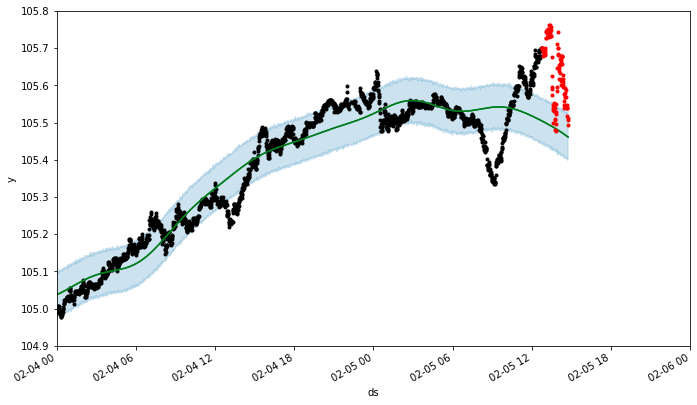

In [52]:
fig = m.plot(forecast)
forecast.set_index('ds')['yhat'].plot(color='g')
df_test.set_index('ds')['y'].plot(color='r', linestyle='', marker='.')

max_dt = datetime.datetime.strptime('20210206', '%Y%m%d')
min_dt = datetime.datetime.strptime('20210204', '%Y%m%d')
plt.xlim(min_dt, max_dt)
plt.ylim(104.9, 105.8)
plt.show()

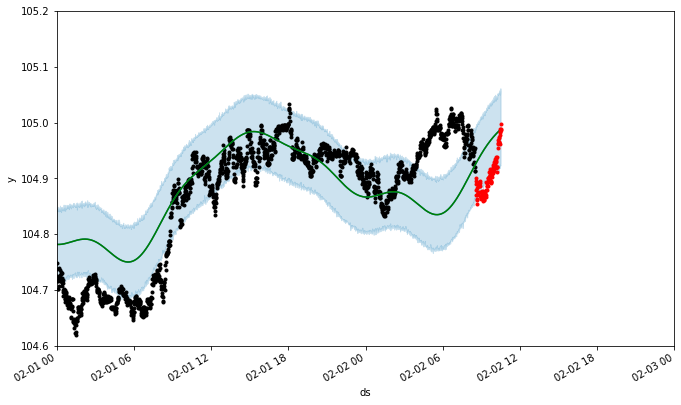

In [21]:
fig = m.plot(forecast)
forecast.set_index('ds')['yhat'].plot(color='g')
df_test.set_index('ds')['y'].plot(color='r', linestyle='', marker='.')

max_dt = datetime.datetime.strptime('20210203', '%Y%m%d')
min_dt = datetime.datetime.strptime('20210201', '%Y%m%d')
plt.xlim(min_dt, max_dt)
plt.ylim(104.6, 105.2)
plt.show()

In [113]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics